<a href="https://colab.research.google.com/github/alouwyck/maxsypy/blob/main/seminaries/UM6P_jan_2025/Seminary_UM6P_Jan_2025_Part_2_Well_known_1D_axisymmetric_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

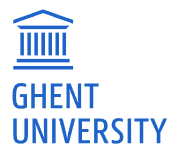<br>


**Axisymmetric Flow in Multilayer Aquifer Systems**<br>
Seminary on Groundwater Modeling<br>
University Mohammed VI Polytechnic<br>
January 6, 2025<br>
Dr. Andy Louwyck

---



---

# **Part 2 - Well-known 1D axisymmetric models**

This notebook contains some code examples that illustrate how to use the well-known solutions for 1D axisymmetric models discussed in the second part of the presentation. The explanation provided with each example is relatively concise. If you want to get a good understanding of what's going on, I recommend reading the notebook side by side with the slides. For a full comprehension of the discussed models, I refer to [my PhD thesis](https://github.com/alouwyck/PhD) (Louwyck, 2023).

## 0. Import statements

We need the following libraries:
- [NumPy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We also clone the MAxSyPy package from GitHub for simulating axisymmetric groundwater flow:

In [2]:
import os, shutil

# remove directory 'maxsypy' first if it already exists
path = "maxsypy"
if os.path.exists(path):
    shutil.rmtree(path)

# clone maxsypy repository from Github
!git clone https://github.com/alouwyck/maxsypy


# put maxsypy package directory in the current working directory
os.rename(path, 'temp')
shutil.copytree(os.path.join('temp', path), path);
shutil.rmtree('temp')

Cloning into 'maxsypy'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 127 (delta 28), reused 0 (delta 0), pack-reused 60 (from 1)
Receiving objects: 100% (127/127), 5.87 MiB | 9.11 MiB/s, done.
Resolving deltas: 100% (62/62), done.


The [MAxSyPy](https://github.com/alouwyck/maxsypy) package implements several analytical and semi-analytical solutions discussed in my PhD thesis (Louwyck, 2023). Importing module `inspect` will allow us to print the source code of the functions implemented in the `maxsypy` package:

In [3]:
import inspect

## 1. The de Glee equation

The de Glee equation is used to simulate steady one-dimensional axisymmetric flow to a pumping well in a leaky aquifer.

We import function `deglee` from module `maxsypy.special`. Note that we also import function `thiem` because we will compare the de Glee equation with the Thiem equation:

In [4]:
from maxsypy.special import deglee, thiem

print(inspect.getdoc(deglee))

Simulate steady flow to a pumping well in a leaky aquifer, which extracts water at a constant pumping rate.

Parameters
----------
r : array_like
  One-dimensional array with the radial distances [L].
T : float
  Aquifer transmissivity [L²/T].
Q : float
  Pumping rate [L³/T] of the well.
r_in : float, default: 0.O
     Pumping well radius [L], which coincides with the inner model boundary.
c_top : float, default: inf
      Vertical resistance [T] of the aquitard overlying the aquifer.
h_top : float, default: 0.0
      Constant head [L] of the upper boundary condition.
c_bot : float, default: inf
      Vertical resistance [T] of the aquitard underlying the aquifer.
h_bot : float, default: 0.0
      Constant head [L] of the lower boundary condition.

Returns
-------
h : ndarray
  Hydraulic heads [L] at distances `r`.
  The length of `h` equals the length of `r`.


Inspecting the documentation of function `deglee`, we see it implements a generalized version of the de Glee equation which also allows a finite-diameter well and leakage at the bottom of the aquifer. Note that the SciPy functions `k0` and `k1` implementing the modified Bessel functions of the second kind can be imported from module `scipy.special`.

We've coded function `thiem` in previous notebook. The `maxsypy` function is very similar:

In [5]:
print(inspect.getsource(thiem))

def thiem(r, T, Q, r_out, h_out=0.0):
    """
    Calculate hydraulic head at given distances r according to the Thiem formula for steady confined flow.

    Parameters
    ----------
    r : array_like
      Radial distances [L], which should be smaller than `r_out`.
    T : float
      Aquifer transmissivity [L²/T].
    Q : float
        Pumping rate [L³/T] of the well.
    r_out : float
          Radial distance [L] of the outer aquifer boundary.
    h_out : float, default: 0.0
          Hydraulic head [L] at the outer aquifer boundary at distance `r_out`.

    Returns
    -------
    h : ndarray
      Hydraulic heads [L] at given distances `r`. The shape of `h` is the same as the shape of `r`.
    """
    r = np.array(r)
    return h_out + Q / 2 / np.pi / T * np.log(r_out / r)



Going back to the example in previous notebook, we also need a resistance `c` in this case. Note that `maxsypy` requires a negative pumping rate when water is extracted from the aquifer:

In [6]:
Q  = -1000         # pumping rate (m³/d): Q < 0 -> extraction
K  = 10            # horizontal conductivity (m/d)
h0 = 20            # initial head = initial aquifer thickness (m)
T  = K * h0        # aquifer transmissivity (m²/d)
c  = 500           # aquitard resistance (d)
L  = np.sqrt(T*c)  # leakage factor (m)

r1 = np.logspace(-2, 5, 100)  # radial distances (m)
h1 = deglee(r=r1, Q=Q, T=T, c_top=c, h_top=h0)  # head (m) according to the de Glee formula

If we want to approximate the head using the Thiem equation, we first need to calculate the radius of influence:

> $R = 2 e^{-\gamma} \sqrt{Tc}$

where $\gamma$ is [Euler's constant](https://en.wikipedia.org/wiki/Euler%27s_constant), which is implemented as NumPy constant `euler_gamma`:

In [7]:
R1 = 2 * np.exp(-np.euler_gamma) * L  # radius of influence (m)
print(R1)

r2 = np.logspace(-2, np.log10(R1), 100)  # radial distances (m)
h2 = thiem(r=r2, Q=Q, T=T, r_out=R1, h_out=h0)  # head (m) according to the Thiem formula

355.0981563946473


A safer way of estimating the radius of influence is taking 4 times the leakage factor:

In [8]:
R2 = 4 * L  # radius of influence (m)
print(R2)

1264.9110640673518


Let's plot the result:

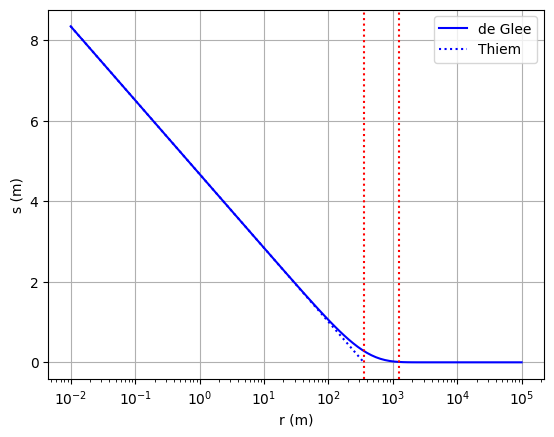

In [9]:
plt.semilogx(r1, h0 - h1, 'b-', label="de Glee");  # drawdown (m) according to de Glee formula
plt.semilogx(r2, h0 - h2, 'b:', label="Thiem");    # drawdown (m) according to Thiem formula
yl = plt.ylim()
plt.semilogx([R1, R1], yl, 'r:')  # 1st radius of influence (m)
plt.semilogx([R2, R2], yl, 'r:')  # 2nd radius of influence (m)
plt.ylim(yl);
plt.xlabel('r (m)');
plt.ylabel('s (m)');
plt.legend();
plt.grid();

## 2. The Theis equation

The Theis equation is used to simulate transient one-dimensional axisymmetric flow to a pumping well in a confined aquifer. It may also be used to simulate flow to a well fully penetrating a phreatic aquifer, under the condition that the drawdown is relatively small compared with the initial saturated thickness of the aquifer.

We import function `theis` from module `maxsypy.special`, and again, we also import function `thiem` because we will approximate the Theis solution by applying the well-known Cooper-Jacob approximation:

In [10]:
from maxsypy.special import theis, thiem

print(inspect.getdoc(theis))

Simulate transient flow to a pumping well in a confined aquifer.
The well has an infinitesimal radius and extracts water at a constant pumping rate.

Parameters
----------
r : array_like
  One-dimensional array with the radial distances [L].
t : array_like
  One-dimensional array with the simulation times [T].
T : float
  Aquifer transmissivity [L²/T].
S : float
  Aquifer storativity [-].
Q : float
  Pumping rate [L³/T] of the well.
h_out : float, default: 0.0
      Constant head [L] at the outer boundary condition, which is also the initial head in the aquifer.

Returns
-------
h : ndarray
  Hydraulic head [L] at distances `r` and times `t`.
  Shape of `h` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.


It is interesting to notice that function `theis` uses SciPy function `exp1` which can be imported again from module `scipy.special`. This function implements the exponential integral, which is how the Theis' well function $W$ is called by mathematicians.

Our previous example is used again to show how function `Theis` is used. In this case, we also need the aquifer storativity `S`:

In [11]:
Q  = -1000   # pumping rate (m³/d): Q < 0 -> extraction
K  = 10      # horizontal conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
S  = 0.1     # aquifer storativity (-)

r1 = np.logspace(-2, 5, 100)  # radial distances (m)
t  = np.logspace(-3, 3, 3)    # simulation times (d)
h1 = theis(r=r1, t=t, Q=Q, T=T, S=S, h_out=h0)  # head (m) according to the Theis equation

Checking the `shape` of head matrix `h1`, it is seen that the number of rows corresponds to the number of distances `r1` whereas the number of columns corresponds to the number of simulation times `t`:

In [12]:
h1.shape

(100, 3)

The Cooper-Jacob approximation states that we can approximate the Theis equation by the Thiem equation for small distances `r` and/or large values of time `t`. To do so, we need to estimate the radius of influence, which is time-dependent in this case:

> $R(t) = \sqrt{\dfrac{4tT}{e^{\gamma}S}}$

In [13]:
R1t = [np.sqrt(4*t*T/S/np.exp(np.euler_gamma)) for t in t]  # list comprehension calculating R(t) for each time t

Let's simulate the corresponding heads using the `thiem` formula:

In [14]:
h2, r2 = [], []
for R1 in R1t:
    r2.append(np.logspace(-2, np.log10(R1), 100))  # radial distances (m)
    h2.append(thiem(r=r2[-1], Q=Q, T=T, h_out=h0, r_out=R1))  # head (m) according to the Thiem formula

Just like for the de Glee model, there is a safer way to estimate the radius of influence by taking 8 times the diffusivity $T/S$:

In [15]:
R2t = [np.sqrt(8*t*T/S) for t in t]

Let's plot the result:

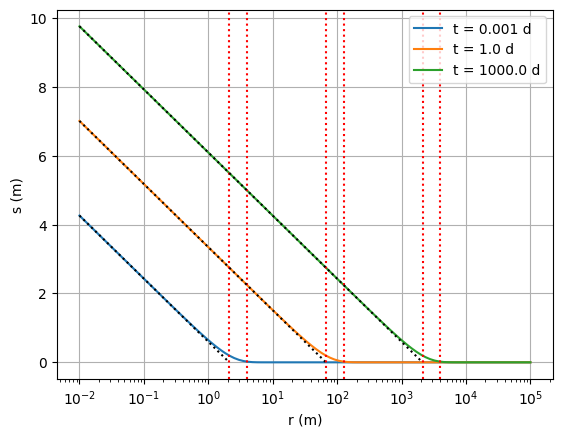

In [16]:
plt.semilogx(r1, h0 - h1, '-');  # drawdown (m) according to the Theis equation
plt.legend(['t = '+ str(t) + ' d' for t in t])
yl = plt.ylim()
for i in range(len(t)):
    plt.semilogx(r2[i], h0 - h2[i], 'k:');  # drawdown (m) according to the Thiem equation
    plt.semilogx([R1t[i], R1t[i]], yl, 'r:');  # 1st radius of influence (m)
    plt.semilogx([R2t[i], R2t[i]], yl, 'r:');  # 2nd radius of influence (m)
plt.ylim(yl);
plt.xlabel('r (m)');
plt.ylabel('s (m)');
plt.grid();

Instead of using SciPy function `exp1`, it is also possible to numerically invert the Theis solution in the Laplace domain using the Stehfest algorithm. Module `maxsypy.special` contains function `stehfest` that implements this algorithm:

In [17]:
from maxsypy.special import stehfest

print(inspect.getdoc(stehfest))

Stehfest algorithm for numerical inversion of Laplace transforms.

Parameters
----------
F : callable
  Function that calculates the Laplace transform. It has frequency parameter `p` [1/T] as input
  and returns the Laplace-transform `F(p)`. Input parameter `p` is a one-dimensional numpy array,
  and the returned output is also a one-dimensional numpy array with the same length as `p`.
t : array_like
  One-dimensional array with the real times `t` [T].
ns : int, default: 12
   Number of terms considered in the Stehfest algorithm applied for the inversion of the Laplace solution.
   Must be a positive, even integer.

Returns
-------
f : ndarray
  One-dimensional array with the numerically inverted values `f(t)`. The length of `f` equals the length of `t`.


The Laplace solution uses the zero order modified Bessel function of the second kind $K_0$, which is imported from module `scipy.special`:

In [18]:
from scipy.special import k0

We see the numerically inverted Laplace solution is virtually the same indeed as the solution that uses the exponential integral:

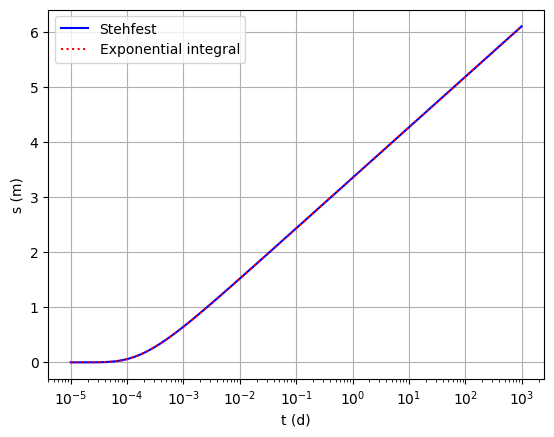

In [19]:
r = 1  # radial distance (m)
t = np.logspace(-5, 3, 100)  # simulation times (d)

sp = lambda p: -Q / 2 / np.pi / T / p * k0(r * np.sqrt(S * p / T))  # Laplace solution
s1 = stehfest(sp, t)  # numerical inversion of Laplace solution

s2 = theis(r=r, t=t, Q=-Q, T=T, S=S)  # solution that applies exp1 function

plt.semilogx(t, s1, 'b-', t, s2.T, 'r:');
plt.legend(['Stehfest', 'Exponential integral']);
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.grid();

## 3. The Hantush-Jacob model

The Hantush-Jacob solution is used to simulate transient one-dimensional axisymmetric flow to a pumping well in a leaky aquifer.

The Hantush-Jacob solution is implemented in function `hantush_jacob`. Because this solution is asymptotical to the Theis and the de Glee solutions, we also import functions `theis` and `deglee` so we can compare them.

When we inspect the code of function `hantush_jacob`, we see there are two possible solution methods:

1. the numerical inversion of the Laplace solution using the Stehfest algorihtm;
2. a fast numerical approximation of the Hantush well function $W$ by Veling & Maas (2010).

In [20]:
from maxsypy.special import hantush_jacob, theis, deglee

print(inspect.getdoc(hantush_jacob))

Simulate transient flow to a pumping well in a leaky aquifer.
The well has an infinitesimal radius and extracts water at a constant pumping rate.

The solution is obtained from numerical inversion of the exact analytical solution in Laplace space.
There is also the option to apply a fast approximation of the Hantush Well function W.
See input parameter `ns`.

Parameters
----------
r : array_like
  One-dimensional array with the radial distances [L].
t : array_like
  One-dimensional array with the simulation times [T].
T : float
  Aquifer transmissivity [L²/T].
S : float
  Aquifer storativity [-].
Q : float
  Pumping rate [L³/T] of the well.
c_top : float
      Vertical resistance [T] of the aquitard overlying the aquifer.
h_top : float, default: 0.0
      Constant head [L] of the upper boundary condition, which is also the initial head in the aquifer.
ns : int, default: 12
   Stehfest number - must be a positive, even integer.
   If `ns` is `None`, then a fast approximation of the Hant

We return to our example to show that the Hantush-Jacob solution can be approximated by the Theis equation for small values of time and that it is virtually the same as the de Glee solution once the flow is in a steady state:

In [21]:
Q  = -1000   # pumping rate (m³/d): Q < 0 -> extraction
K  = 10      # horizontal conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
c  = 500     # aquitard resistance (d)
S  = 0.1     # aquifer storativity (-)

r  = np.logspace(-1, 2, 4)    # radial distances (m)
t  = np.logspace(-5, 5, 100)  # simulation times (d)
h1 = hantush_jacob(r=r, t=t, Q=Q, T=T, S=S, c_top=c, h_top=h0)  # head (m) according to Hantush-Jacob
h2 = theis(r=r, t=t, Q=Q, T=T, S=S, h_out=h0)  # head (m) according to Theis
h3 = deglee(r=r, Q=Q, T=T, c_top=c, h_top=h0)  # head (m) according to de Glee

Plotting the result:

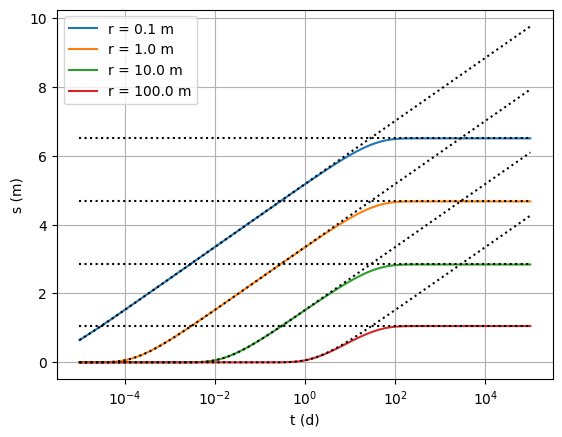

In [22]:
plt.semilogx(t, h0 - h1.T, '-');  # drawdown (m) according to Hantush-Jacob
plt.legend(['r = '+ str(r) + ' m' for r in r])
plt.semilogx(t, h0 - h2.T, 'k:');  # drawdown (m) according to Theis
plt.semilogx(t[[0, -1]], np.tile(h0 - h3, (2, 1)), 'k:');  # drawdown (m) according to de Glee
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.grid();

## 4. The Ernst model

The Ernst solution is used to simulate steady one-dimensional axisymmetric flow to a pumping well in a phreatic aquifer subject to uniform areal recharge and nonlinear drainage. Although the aquifer is phreatic, its transmissivity is constant.

The Ernst solution is implemented in function `ernst`. Because this solution is asymptotical to the solution of a well extracting a circular island with recharge and to the de Glee solution, we also import functions `bredehoeft` and `deglee` so we can compare them. The function `bredehoeft` is named after the hydrogeologist John Bredehoeft who used the circular island example in his papers debunking the water budget myth. The solution is found by superimposing the Thiem equation and the solution of a circular infiltration pond.

In [23]:
from maxsypy.special import ernst, bredehoeft, deglee

print(inspect.getdoc(ernst))

Simulate steady flow to a pumping well in a phreatic aquifer subject to uniform recharge and drainage.
The well is fully penetrating and extracts water at a constant pumping rate.

Parameters
----------
r : array_like
  One-dimensional array with the radial distances [L].
T : float
  Aquifer transmissivity [L²/T].
c : float
  Drainage resistance [T].
N : float
  Infiltration flux [L/T].
Q : float
  Pumping rate [L³/T] of the well. 
  Negative as the model only simulates extractions.

Returns
-------
s : ndarray
  Drawdown [L] at distances `r`.
  The length of `s` equals the length of `r`.


We consider the same example as before, and this time we also need to define the infiltration flux `N`. In Belgium, a recharge of 200 mm/y is a realistic value.

In [24]:
Q  = -1000             # pumping rate (m³/d): Q < 0 -> extraction
K  = 10                # horizontal conductivity (m/d)
h0 = 20                # initial head = initial aquifer thickness (m)
T  = K * h0            # aquifer transmissivity (m²/d)
N  = 200 / 1000 / 365  # infiltration flux (m/d)
print("N =", N, "m/d")

N = 0.0005479452054794521 m/d


We see that the Ernst solution can be approximated by the combined solution of a circular infiltration pond and the Thiem equation for small values drainage resistance `c`, and that it is virtually the same as the de Glee solution when resistance `c` is large:

R =  762.1781565260303 m


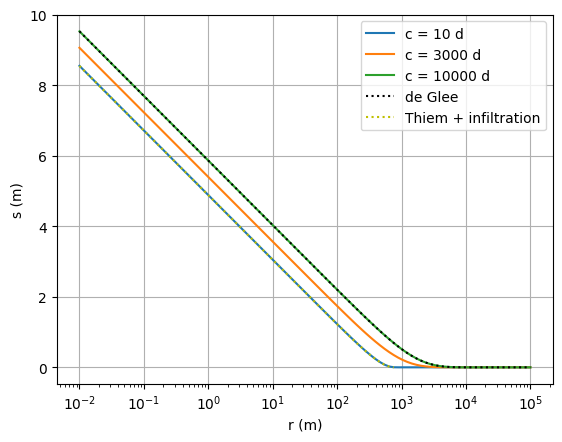

In [25]:
r = np.logspace(-2, 5, 100)  # radial distances (m)

# Ernst
for c in [10, 3000, 10_000]:  # drainage resistances (d)
    s = ernst(r=r, T=T, c=c, N=N, Q=Q)  # drawdown (m)
    plt.semilogx(r, s, '-', label="c = "+ str(c) + " d");

# Approximation for large c: de Glee
s = -deglee(r=r, T=T, c_top=c, Q=Q)  # drawdown (m)
plt.semilogx(r, s, 'k:', label='de Glee');

# Approximation for small c: Thiem + circular infiltration pond
R = np.sqrt(-Q / np.pi / N)  #  radius of influence (m)
print("R = ", R, "m")
s = -bredehoeft(r=r[r<=R], T=T, Q=Q, N=N, r_out=R)  # drawdown (m)
plt.semilogx(r[r<=R], s, 'y:', label='Thiem + infiltration');

plt.legend();
plt.xlabel('r (m)');
plt.ylabel('s (m)');
plt.grid();

## 5. TimML

To simulate a steady-state de Glee model, it is also possible to use TimML, which we've introduced in previous notebook.

First, we need to install TimML:

In [26]:
!pip install timml -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00


After installing the TimML package, we import it:

In [27]:
import timml

Recall that the first step in a TimML simulation is to create a model and define the aquifer properties:

In [28]:
model = timml.ModelMaq(
    kaq=T,               # hydraulic conductivity (m/d)
    c=c,                 # resistance (d)
    z=[2, 1, 0],         # top and bottom of layers (m)
    topboundary='semi',  # semi-confined top
    hstar=0,             # constant head above top (m)
)

Note that the thickness of the layers is set to unit so we can assign transmissivity `T` to `Kaq`, and by setting `hstar` to zero, the model will simulate drawdowns instead of heads. This is possible because the model is linear.

Once the model is created, we can add the `Well`:

In [29]:
well = timml.Well(
    model=model,  # model to which element is added
    xw=0,         # x-location of well (m)
    yw=0,         # y-location of well (m)
    Qw=-Q,        # pumping rate of well (m³/d), positive for extraction
    rw=r[0],      # well radius (m), we take the first element of r
)

In this case, we don't define an outer constant-head boundary, as it is at an infinitely large distance from the pumping well. Actually, the de Glee model defines a constant-head on top of the model. So we're ready to solve the model:

In [30]:
model.solve()

We want to compare the TimML results with the drawdown returned by the exact formula of `deglee`, so we first calculate the latter. Here, we also calculate drawdowns instead of heads by setting `h_top` to zero:

In [31]:
s1 = -deglee(r=r, Q=Q, T=T, c_top=c, h_top=0)  # drawdown (m) according to the de Glee formula

Calculating the drawdowns at distances `r` using the TimML model:

In [32]:
s2 = -np.array([model.head(x=r, y=0) for r in r])  # drawdown (m)

Both solutions are virtually the same indeed:

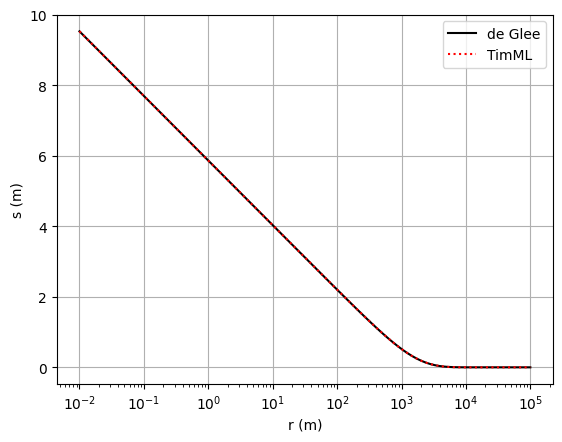

In [33]:
plt.semilogx(r, s1, 'k-', label='de Glee');
plt.semilogx(r, s2, 'r:', label='TimML');
plt.legend();
plt.xlabel('r (m)');
plt.ylabel('s (m)');
plt.grid();

Simulating an Ernst model using TimML is possible, but not straightforward, and therefore not illustrated here.

## 6. TTim

As TimML can only treat steady-state flow, it is not possible to simulate a Theis or Hantush-Jacob model. Fortunately, [Mark Bakker](https://www.tudelft.nl/citg/over-faculteit/afdelingen/watermanagement/medewerker/staff-hydrology/academic-staff/profdrir-mark-bakker) developed [TTim](https://ttim.readthedocs.io/en/latest/), a Python package for the modeling of *transient* multi-layer groundwater flow with analytic elements.

First, we need to install TTim:

In [34]:
!pip install ttim -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.9 MB/s eta 0:00:00


After installing the TTim package, we import it:

In [35]:
import ttim

### Theis

First, let us simulate the Theis model using function `theis`:

In [36]:
r  = np.logspace(-1, 1, 3)    # radial distances (m)
t  = np.logspace(-5, 3, 100)  # simulation times (d)
s1 = theis(r=r, t=t, Q=Q, T=T, S=S)  # drawdown (m) according to the Theis equation

The steps to simulate a TTim model are the same as for a TimML model:

In [37]:
model = ttim.ModelMaq(
    kaq=K,               # hydraulic conductivity (m/d)
    Saq=S/h0,            # specific storage (1/m)
    c=c,                 # resistance (d)
    z=[h0, 0],           # top and bottom of layers (m)
    tmin=1e-5,           # the minimum time for which heads can be computed (d)
    tmax=1e3             # the maximum time for which heads can be computed (d)
)

As flow is transient, specific storage `Saq` must be defined, and a minimum and maximum time. The `Well` also requires a start time:

In [38]:
well = ttim.Well(
    model,             # model to which element is added
    xw=0,              # x-location of well (m)
    yw=0,              # y-location of well (m)
    tsandQ=[(0, -Q)],  # start time (d), pumping rate (m³/d)
    rw=1e-5            # well radius (m), set to a very small number as rw -> 0
)

Solving the model:

In [39]:
model.solve()

self.neq  1
solution complete


Calculating the drawdowns using method `head`:

In [40]:
s2 = np.array([model.head(r, 0, t).flatten() for r in r])

Plotting the result:

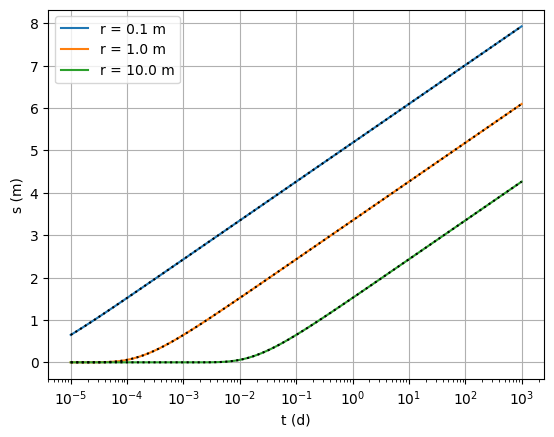

In [41]:
plt.semilogx(t, -s1.T, '-');   # drawdown (m) according to Theis
plt.legend(['r = '+ str(r) + ' m' for r in r]);
plt.semilogx(t, -s2.T, 'k:');  # drawdown (m) according to TTim
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.grid();

The time-drawdown curves simulated using both methods virtually coincide!

### Hantush-Jacob

First, let us simulate the Hantush-Jacob model using function `hantush_jacob`:

In [42]:
r  = np.logspace(-1, 1, 3)    # radial distances (m)
t  = np.logspace(-5, 5, 100)  # simulation times (d)
s1 = hantush_jacob(r=r, t=t, Q=Q, T=T, S=S, c_top=c)  # drawdown (m) according to Hantush-Jacob

Building the TTim model:

In [43]:
model = ttim.ModelMaq(
    kaq=T,               # hydraulic conductivity (m/d)
    Saq=S,               # specific storage (1/m)
    c=c,                 # resistance (d)
    z=[2, 1, 0],         # top and bottom of layers (m)
    topboundary="semi",  # semi-confined top
    tmin=1e-5,           # the minimum time for which heads can be computed (d)
    tmax=1e5             # the maximum time for which heads can be computed (d)
)

Note that we set layer thicknesses to unity so we can assign `T` and `S` to `kaq` and `Saq`, respectively.

Adding the `Well`:

In [44]:
well = ttim.Well(
    model,             # model to which element is added
    xw=0,              # x-location of well (m)
    yw=0,              # y-location of well (m)
    tsandQ=[(0, -Q)],  # start time (d), pumping rate (m³/d)
    rw=1e-5            # well radius (m), set to a very small number as rw -> 0
)

Solving the model:

In [45]:
model.solve()

self.neq  1
solution complete


Calculating the drawdowns using method `head`:

In [46]:
s2 = np.array([model.head(r, 0, t).flatten() for r in r])

Plotting the result:

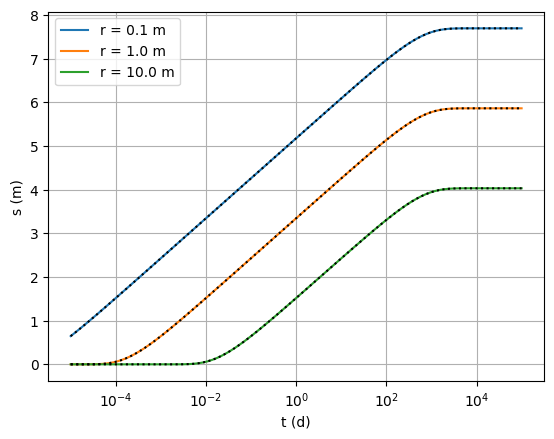

In [47]:
plt.semilogx(t, -s1.T, '-');   # drawdown (m) according to Hantush-Jacob
plt.legend(['r = '+ str(r) + ' m' for r in r]);
plt.semilogx(t, -s2.T, 'k:');  # drawdown (m) according to TTim
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.grid();

Again, both solution methods virtually give the same result!

---